<a href="https://colab.research.google.com/github/Hrishkesh/Invoice-/blob/master/Invoice_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --user tensorflow-gpu==2.0.0 -q

In [2]:
!pip install --user tensorboard -q

In [3]:
!pip install --upgrade wandb -q
!wandb login 47ae077cee2c514d2b004ca904e0a365185a06c1

     |████████████████████████████████| 1.4MB 3.3MB/s 
     |████████████████████████████████| 112kB 10.5MB/s 
     |████████████████████████████████| 163kB 10.7MB/s 
     |████████████████████████████████| 102kB 6.6MB/s 
     |████████████████████████████████| 102kB 4.9MB/s 
     |████████████████████████████████| 71kB 4.6MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
!git clone https://github.com/Hrishkesh/Invoice-.git

Cloning into 'Invoice-'...
remote: Enumerating objects: 195, done.
remote: Total 195 (delta 0), reused 0 (delta 0), pack-reused 195
Receiving objects: 100% (195/195), 24.02 MiB | 31.70 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
!pwd

In [4]:
!ls Invoice-/

Data_visualization.ipynb  network.py		preprocessing_ter.py
example.png		  preprocessing_bis.py	README.md
Invoice_new.ipynb	  preprocessing.py	test.ipynb


In [5]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
os.environ['GITHUB_USER'] = user
os.environ['GITHUB_PASSWORD'] = user

GitHub user··········
GitHub password··········


In [6]:
!git config --global user.email "hrishkesh.pattepu@gmail.com"
!git config --global user.name "Hrishkesh"

In [7]:
!cd Invoice- && git remote set-url origin https://$GITHUB_AUTH@github.com/$GITHUB_USER/Invoice-.git

In [9]:
!cd Invoice- && git pull

Already up to date.


In [8]:
!cd Invoice- && git add .

In [10]:
!cd Invoice- && git commit -m "training"

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [11]:
!cd Invoice- && git push

Everything up-to-date


In [ ]:
!pip install colab_ssh --upgrade

In [ ]:
!wget https://www.dropbox.com/s/bzztxbuf2nm2k4o/network.zip

In [13]:
!mkdir /content/data

In [ ]:
!unzip network.zip -d /content/data/

In [18]:
!ls /content/

data  drive  Invoice-  sample_data  wandb


In [ ]:
# from colab_ssh import launch_ssh, init_git
# from getpass import getpass
# ngrokToken = '1cfbiKCtHgohcxmNMIXe34CpbET_7GibpvfZdp55n7ordbjoT'
# #password = getpass('Password of your choice')
# password = 'root'
# launch_ssh(ngrokToken,password)

In [19]:

"""
Main program to train and test the chargrid model

Requirements
----------
- One-hot Chargrid arrays must be located in the folder dir_np_chargrid_1h = "./data/np_chargrids_1h/"
- One-hot Segmentation arrays must be located in the folder dir_np_gt_1h = "./data/np_gt_1h/"
- Bounding Box anchor masks must be located in the folder dir_np_bbox_anchor_mask = "./data/np_bbox_anchor_mask/"
- Bounding Box anchor coordinates must be located in the folder dir_np_bbox_anchor_coord = "./data/np_bbox_anchor_coord/"

Hyperparameters
----------
- (width, height, input_channels) : input shape of one-hot chargrids
- base_channels : number of base channels for the neural network
- (learning_rate, momentum) : parameters of the optimizer
- weight_decay : coefficient used by the l2-regularizer
- spatial_dropout : dropout rate
- nb_classes : number of classes
- proba_classes : probability of each class to appear (classes in this order: other, total, address, company, date)
- constant_weight : constant used to balance class weights
- nb_anchors : number of anchors
- (epochs, batch_size) : parameters for the training process
- prop_test : proportion of the dataset used to validate the model
- seed : seed used to generate randomness (shuffling, ...)
- (pad_left_range, pad_top_range, pad_right_range, pad_bot_range) : padding range used for data augmentation

Return
----------
Several files are generated in the "./output/" folder :
- filename_backup = "./output/model.ckpt" : the model weights for post-training use
- "global_loss.pdf" : plot of the curve containing the global loss functions
- "output_1_loss.pdf" : plot of the curve containing the segmentation loss functions
- "output_2_loss.pdf" : plot of the curve containing the anchor mask loss functions
- "output_3_loss.pdf" : plot of the curve containing the anchor coordinate loss functions
- "train_time.pdf" : plot the time spent to train each epoch
- "test_time.pdf"  : plot the time spent to validate each epoch
"""

import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import os
import time
from skimage.transform import resize, rescale
from datetime import datetime
from tensorflow import keras
import wandb
from wandb.keras import WandbCallback
wandb.init(project="invoice-new")

W&B Run: https://app.wandb.ai/hrishkeshpattepu/invoice-new/runs/8w85zpxa

In [102]:
## Hyperparameters
dir_np_chargrid_1h = "/content/data/outdir_np_chargrid_1h/"
dir_np_gt_1h = "/content/data/outdir_np_gt_1h/"
dir_np_bbox_anchor_mask = "/content/data/outdir_np_bbox_anchor_mask/"
dir_np_bbox_anchor_coord = "/content/data/outdir_np_bbox_anchor_coord/"
width = 128
height = 256
input_channels = 61
base_channels = 64
learning_rate = 0.05
momentum = 0.9
weight_decay = 0.1
spatial_dropout = 0.1
nb_classes = 5
proba_classes = np.array([0.89113252, 0.0113842, 0.0502577, 0.03224928, 0.0149763]) #other, total, address, company, date
constant_weight = 1.04
nb_anchors = 4 # one per foreground class
epochs = 350
batch_size = 6
prop_test = 0.2
seed = 123456
model_dir = '/content/data/output/models/'
filename_backup = "/content/data/output/model.ckpt"
pad_left_range = 0.2
pad_top_range = 0.2
pad_right_range = 0.2
pad_bot_range = 0.2

np.random.seed(seed=seed)

In [103]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [104]:
def print_hardware_configuration():
    print(device_lib.list_local_devices())
    print("Tensorflow version: ", tf.__version__)
    print("Test GPU: ", tf.test.gpu_device_name())

## Data Exploration

In [105]:
list_filenames = [f for f in os.listdir(dir_np_chargrid_1h) if os.path.isfile(os.path.join(dir_np_chargrid_1h, f))]

In [106]:
print("Number of chargrid files: " + str(len(os.listdir(dir_np_chargrid_1h))))
print("Number of segmentation mask files: " + str(len(os.listdir(dir_np_gt_1h))))
print("Number of anchor mask files: " + str(len(os.listdir(dir_np_bbox_anchor_mask))))
print("Number of bounding box anchor files: " + str(len(os.listdir(dir_np_bbox_anchor_coord))))

Number of chargrid files: 602
Number of segmentation mask files: 602
Number of anchor mask files: 602
Number of bounding box anchor files: 602


In [107]:
def get_train_test_sets(list_filenames):
    np.random.shuffle(list_filenames)
    
    trainset = list_filenames[int(len(list_filenames)*prop_test):]
    testset = list_filenames[:int(len(list_filenames)*prop_test)]
    
    return trainset, testset

In [108]:
def extract_batch(dataset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range): # Data augmentation
    if batch_size > len(dataset):
        raise NameError('batch_size > len(dataset)')
    np.random.shuffle(dataset)
    
    tab_rand = np.random.rand(batch_size, 4)*[pad_left_range*width, pad_top_range*height, pad_right_range*width, pad_bot_range*height]
    tab_rand = tab_rand.astype(int)
    
    chargrid_input = []
    seg_gt = []
    anchor_mask_gt = []
    anchor_coord_gt = []
    
    for i in range(0, batch_size):
        data = np.load(os.path.join(dir_np_chargrid_1h, dataset[i])) # 256,128,61
        chargrid_input.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, input_channels)))  # 256,128,61
        
        data = np.load(os.path.join(dir_np_gt_1h, dataset[i]))  # 256,128,5
        seg_gt.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, nb_classes)))  # 256,128,5
        
        data = np.load(os.path.join(dir_np_bbox_anchor_mask, dataset[i]))  # 256,128,8
        anchor_mask_gt.append(augment_data(data, tab_rand[i], order=1, shape=(height, width, 2*nb_anchors)))  # 256,128,8
        
        data = np.load(os.path.join(dir_np_bbox_anchor_coord, dataset[i]))  #256,128,16
        anchor_coord_gt.append(augment_data(data, tab_rand[i], order=0, shape=(height, width, 4*nb_anchors), coord=True)) #256,128,16
        
    return np.array(chargrid_input), np.array(seg_gt), np.array(anchor_mask_gt), np.array(anchor_coord_gt)


In [109]:
def augment_data(data, tab_rand, order, shape, coord=False):
    data_temp = resize(np.pad(data, ((tab_rand[1], tab_rand[3]), (tab_rand[0], tab_rand[2]), (0, 0)), 'constant'), shape, order=order, anti_aliasing=True)
    
    if coord:
        for i in range(0, nb_anchors):
            mask = (data_temp > 1e-6)[:, :, 4*i]
            data_temp[mask, 4*i] *= shape[1]
            data_temp[mask, 4*i] += tab_rand[0]
            data_temp[mask, 4*i] /= (tab_rand[0]+shape[1]+tab_rand[2])
            
            data_temp[mask, 4*i+2] *= shape[1]
            data_temp[mask, 4*i+2] += tab_rand[0]
            data_temp[mask, 4*i+2] /= (tab_rand[0]+shape[1]+tab_rand[2])
            
            data_temp[mask, 4*i+1] *= shape[0]
            data_temp[mask, 4*i+1] += tab_rand[1]
            data_temp[mask, 4*i+1] /= (tab_rand[1]+shape[0]+tab_rand[3])
            
            data_temp[mask, 4*i+3] *= shape[0]
            data_temp[mask, 4*i+3] += tab_rand[1]
            data_temp[mask, 4*i+3] /= (tab_rand[1]+shape[0]+tab_rand[3])

    return data_temp

In [110]:
trainset, testset = get_train_test_sets(list_filenames)
print("trainset: ", len(trainset), " - testset: ", len(testset))
batch_chargrid, batch_seg, batch_mask, batch_coord = extract_batch(trainset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range)

trainset:  482  - testset:  120


In [111]:
print("Shape of chargrid batch: ", batch_chargrid.shape)
print("Shape of seg mask batch", batch_seg.shape)
print("Shape of anchor mask batch", batch_mask.shape)
print("Shape of bb coordinates batch", batch_coord.shape)

Shape of chargrid batch:  (6, 256, 128, 61)
Shape of seg mask batch (6, 256, 128, 5)
Shape of anchor mask batch (6, 256, 128, 8)
Shape of bb coordinates batch (6, 256, 128, 16)


In [112]:
np.argmax(batch_chargrid, axis=3)[0].shape

(256, 128)

In [113]:
import matplotlib.patches as patches
import random

In [114]:
index = random.randint(0,5)
index

1

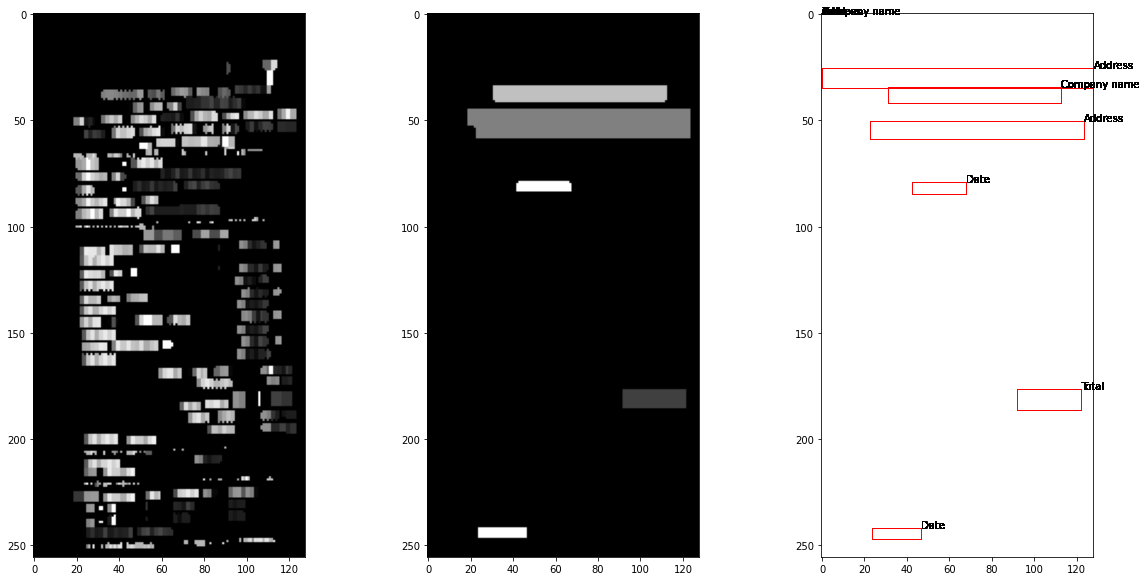

In [115]:
class_mapping = {
                0 : 'Total', 
                1 : 'Address', 
                2 : 'Company name', 
                3 : 'Date'
} 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(np.argmax(batch_chargrid[index], axis=2), cmap='gray')
ax[1].imshow(np.argmax(batch_seg[index], axis=2), cmap='gray')
white = np.zeros([batch_chargrid[index].shape[0], batch_chargrid[index].shape[1],3],dtype=np.uint8)
white.fill(255)
ax[2].imshow(white)
for i in range(0, batch_coord[index].shape[0]):
  for j in range(0, batch_coord[index].shape[1]):
    if (np.sum(batch_coord[index][i][j])==0):
      continue
    # print(batch_coord[1][i][j])
    for k in range(0, len(class_mapping)):
      left = batch_coord[index][i][j][4*k] * width
      top = batch_coord[index][i][j][4*k+1] * height
      right = batch_coord[index][i][j][4*k+2] * width
      bottom = batch_coord[index][i][j][4*k+3] * height
      rect1 = patches.Rectangle((left, top),
                        (right - left),
                        (bottom - top),
                        linewidth=1,edgecolor='r',facecolor='none')
      ax[2].add_patch(rect1)
      ax[2].text(left + (right - left),top,class_mapping[k]) 
plt.show()


In [116]:
class Network(tf.keras.Model):
    def __init__(self):
        super(Network, self).__init__()
        ## Block z
        self.z1 = tf.keras.layers.Conv2D(input_shape=(None, height, width, input_channels), filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z1_bn = tf.keras.layers.BatchNormalization()

        self.z2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z2_bn = tf.keras.layers.BatchNormalization()
        
        self.z3 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.z3_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.z3_bn = tf.keras.layers.BatchNormalization()
        
        self.z4 = tf.keras.layers.Dropout(rate=spatial_dropout)
        
        ## Block a
        self.a1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a1_bn = tf.keras.layers.BatchNormalization()

        self.a2 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a2_bn = tf.keras.layers.BatchNormalization()
        
        self.a3 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.a3_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.a3_bn = tf.keras.layers.BatchNormalization()
        
        self.a4 = tf.keras.layers.Dropout(rate=spatial_dropout)


        ## Block a_bis
        self.a_bis_filters = [4*base_channels, 8*base_channels, 8*base_channels]
        self.a_bis_stride = [2, 2, 1]
        self.a_bis_dilatation = [2, 4, 8]
        
        self.a_bis1 = []
        self.a_bis1_lrelu = []
        self.a_bis1_bn = []
        
        self.a_bis2 = []
        self.a_bis2_lrelu = []
        self.a_bis2_bn = []
        
        self.a_bis3 = []
        self.a_bis3_lrelu = []
        self.a_bis3_bn = []
        
        self.a_bis4 = []
        
        for i in range(0, len(self.a_bis_filters)):
            self.a_bis1.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=self.a_bis_stride[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis1_bn.append(tf.keras.layers.BatchNormalization())

            self.a_bis2.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=1, dilation_rate=self.a_bis_dilatation[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.a_bis3.append(tf.keras.layers.Conv2D(filters=self.a_bis_filters[i], kernel_size=3, strides=1, dilation_rate=self.a_bis_dilatation[i], padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.a_bis3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.a_bis3_bn.append(tf.keras.layers.BatchNormalization())
        
            self.a_bis4.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block b_ss (semantic segmentation)
        self.b_ss_filters = [4*base_channels, 2*base_channels]
        
        self.b_ss1 = []
        self.b_ss1_lrelu = []
        self.b_ss1_bn = []
        
        self.b_ss2 = []
        self.b_ss2_lrelu = []
        self.b_ss2_bn = []
        
        self.b_ss3 = []
        self.b_ss3_lrelu = []
        self.b_ss3_bn = []
        
        self.b_ss4 = []
        self.b_ss4_lrelu = []
        self.b_ss4_bn = []
        
        self.b_ss5 = []
        
        for i in range(0, len(self.b_ss_filters)):
            self.b_ss1.append(tf.keras.layers.Conv2D(filters=2*self.b_ss_filters[i], kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss1_bn.append(tf.keras.layers.BatchNormalization())

            self.b_ss2.append(tf.keras.layers.Conv2DTranspose(filters=self.b_ss_filters[i], kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_ss3.append(tf.keras.layers.Conv2D(filters=self.b_ss_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss3_bn.append(tf.keras.layers.BatchNormalization())
            
            self.b_ss4.append(tf.keras.layers.Conv2D(filters=self.b_ss_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_ss4_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_ss4_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_ss5.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block b_bbr (bounding box regression)
        self.b_bbr_filters = [4*base_channels, 2*base_channels]
        
        self.b_bbr1 = []
        self.b_bbr1_lrelu = []
        self.b_bbr1_bn = []
        
        self.b_bbr2 = []
        self.b_bbr2_lrelu = []
        self.b_bbr2_bn = []
        
        self.b_bbr3 = []
        self.b_bbr3_lrelu = []
        self.b_bbr3_bn = []
        
        self.b_bbr4 = []
        self.b_bbr4_lrelu = []
        self.b_bbr4_bn = []
        
        self.b_bbr5 = []
        
        for i in range(0, len(self.b_bbr_filters)):
            self.b_bbr1.append(tf.keras.layers.Conv2D(filters=2*self.b_bbr_filters[i], kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr1_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr1_bn.append(tf.keras.layers.BatchNormalization())

            self.b_bbr2.append(tf.keras.layers.Conv2DTranspose(filters=self.b_bbr_filters[i], kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr2_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr2_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_bbr3.append(tf.keras.layers.Conv2D(filters=self.b_bbr_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr3_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr3_bn.append(tf.keras.layers.BatchNormalization())
            
            self.b_bbr4.append(tf.keras.layers.Conv2D(filters=self.b_bbr_filters[i], kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay)))
            self.b_bbr4_lrelu.append(tf.keras.layers.LeakyReLU(alpha=0.2))
            self.b_bbr4_bn.append(tf.keras.layers.BatchNormalization())
        
            self.b_bbr5.append(tf.keras.layers.Dropout(rate=spatial_dropout))
        
        
        ## Block c_ss
        self.c_ss1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_ss1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_ss1_bn = tf.keras.layers.BatchNormalization()

        self.c_ss2 = tf.keras.layers.Conv2DTranspose(filters=base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_ss2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_ss2_bn = tf.keras.layers.BatchNormalization()
        
        
        ## Block c_bbr
        self.c_bbr1 = tf.keras.layers.Conv2D(filters=2*base_channels, kernel_size=1, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_bbr1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_bbr1_bn = tf.keras.layers.BatchNormalization()

        self.c_bbr2 = tf.keras.layers.Conv2DTranspose(filters=base_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.c_bbr2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.c_bbr2_bn = tf.keras.layers.BatchNormalization()
        
        
        ## Block d
        self.d1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.d1_bn = tf.keras.layers.BatchNormalization()

        self.d2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.d2_bn = tf.keras.layers.BatchNormalization()
        
        self.d3 = tf.keras.layers.Conv2D(filters=nb_classes, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.d3_softmax = tf.keras.layers.Softmax()
        
        
        ## Block e
        self.e1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.e1_bn = tf.keras.layers.BatchNormalization()

        self.e2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.e2_bn = tf.keras.layers.BatchNormalization()
        
        self.e3 = tf.keras.layers.Conv2D(filters=2*nb_anchors, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.e3_softmax = tf.keras.layers.Softmax()
        
        
        ## Block f
        self.f1 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.f1_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.f1_bn = tf.keras.layers.BatchNormalization()

        self.f2 = tf.keras.layers.Conv2D(filters=base_channels, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.he_uniform(), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))
        self.f2_lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.f2_bn = tf.keras.layers.BatchNormalization()
        
        self.f3 = tf.keras.layers.Conv2D(filters=4*nb_anchors, kernel_size=3, strides=1, padding="same", kernel_initializer=tf.constant_initializer(value=1e-3), kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay))


    def call(self, input):
        ## Input shape 256, 128, 61
        ## 61 channels because 61 significant characters out of 93 distinct characters
        ## Encoder
        x = self.z1(input) ## 256, 128, 64
        x = self.z1_lrelu(x) ## 256, 128, 64
        x = self.z1_bn(x) ## 256, 128, 64
        x = self.z2(x)  ## 256, 128, 64
        x = self.z2_lrelu(x)
        x = self.z2_bn(x)
        x = self.z3(x)
        x = self.z3_lrelu(x)
        x = self.z3_bn(x)
        out_z = self.z4(x)  ## 256, 128, 64
        
        x = self.a1(out_z)
        x = self.a1_lrelu(x)
        x = self.a1_bn(x)
        x = self.a2(x)
        x = self.a2_lrelu(x)
        x = self.a2_bn(x)
        x = self.a3(x)
        x = self.a3_lrelu(x)
        x = self.a3_bn(x)
        out_a = self.a4(x)  # 128, 64, 128
        
        out_a_bis = []  # [(64 , 32 , 256), (32, 16, 512), (32, 16, 512)]
        x = out_a
        for i in range(0, len(self.a_bis_filters)):
            x = self.a_bis1[i](x)
            x = self.a_bis1_lrelu[i](x)
            x = self.a_bis1_bn[i](x)
            x = self.a_bis2[i](x)
            x = self.a_bis2_lrelu[i](x)
            x = self.a_bis2_bn[i](x)
            x = self.a_bis3[i](x)
            x = self.a_bis3_lrelu[i](x)
            x = self.a_bis3_bn[i](x)
            x = self.a_bis4[i](x)
            out_a_bis.append(x)  
        
        ## Decoder Semantic Segmentation
        concat_tab = [out_a_bis[1], out_a_bis[0]]  # Why 0 and 1?
        for i in range(0, len(self.b_ss_filters)):
            x = tf.concat([x, concat_tab[i]], 3)
            x = self.b_ss1[i](x)
            x = self.b_ss1_lrelu[i](x)
            x = self.b_ss1_bn[i](x)
            x = self.b_ss2[i](x)
            x = self.b_ss2_lrelu[i](x)
            x = self.b_ss2_bn[i](x)
            x = self.b_ss3[i](x)
            x = self.b_ss3_lrelu[i](x)
            x = self.b_ss3_bn[i](x)
            x = self.b_ss4[i](x)
            x = self.b_ss4_lrelu[i](x)
            x = self.b_ss4_bn[i](x)
            x = self.b_ss5[i](x)

        ## 128, 64, 128
        
        x = tf.concat([x, out_a], 3)
        x = self.c_ss1(x)
        x = self.c_ss1_lrelu(x)
        x = self.c_ss1_bn(x)
        x = self.c_ss2(x)
        x = self.c_ss2_lrelu(x)
        x = self.c_ss2_bn(x)
        
        x = self.d1(x)
        x = self.d1_lrelu(x)
        x = self.d1_bn(x)
        x = self.d2(x)
        x = self.d2_lrelu(x)
        x = self.d2_bn(x)
        x = self.d3(x)
        out_d = self.d3_softmax(x)  ## 256, 128, 5
        
        ## Decoder Bounding Box Regression
        concat_tab = [out_a_bis[1], out_a_bis[0]]
        x = out_a_bis[-1]
        for i in range(0, len(self.b_bbr_filters)):
            x = tf.concat([x, concat_tab[i]], 3)
            x = self.b_bbr1[i](x)
            x = self.b_bbr1_lrelu[i](x)
            x = self.b_bbr1_bn[i](x)
            x = self.b_bbr2[i](x)
            x = self.b_bbr2_lrelu[i](x)
            x = self.b_bbr2_bn[i](x)
            x = self.b_bbr3[i](x)
            x = self.b_bbr3_lrelu[i](x)
            x = self.b_bbr3_bn[i](x)
            x = self.b_bbr4[i](x)
            x = self.b_bbr4_lrelu[i](x)
            x = self.b_bbr4_bn[i](x)
            x = self.b_bbr5[i](x)
        
        x = tf.concat([x, out_a], 3)
        x = self.c_bbr1(x)
        x = self.c_bbr1_lrelu(x)
        x = self.c_bbr1_bn(x)
        x = self.c_bbr2(x)
        x = self.c_bbr2_lrelu(x)
        out_c_bbr = self.c_bbr2_bn(x)
        
        x = self.e1(out_c_bbr)
        x = self.e1_lrelu(x)
        x = self.e1_bn(x)
        x = self.e2(x)
        x = self.e2_lrelu(x)
        x = self.e2_bn(x)
        x = self.e3(x)
        out_e = self.e3_softmax(x)
        
        x = self.f1(out_c_bbr)
        x = self.f1_lrelu(x)
        x = self.f1_bn(x)
        x = self.f2(x)
        x = self.f2_lrelu(x)
        x = self.f2_bn(x)
        out_f = self.f3(x)
        
        return out_d, out_e, out_f ## out_d --> (256,128,5), out_e --> (256, 128, 8) , out_f --> (256, 128, 16)


In [117]:
def get_class_weights():
    sample_weight_seg = np.ones((height, width, nb_classes))*1.0/np.log(constant_weight+proba_classes)

    proba_classes_boxmask = np.repeat(proba_classes[1:], 2)
    proba_classes_boxmask[np.arange(1, 2*nb_anchors, 2)] = 1-proba_classes[1:]
    sample_weight_boxmask = np.ones((height, width, 2*nb_anchors))*1.0/np.log(constant_weight+proba_classes_boxmask)
    
    return sample_weight_seg, sample_weight_boxmask

In [118]:
def initialize_network(sample_weight_seg, sample_weight_boxmask):
    net = Network()
    
    losses = {'output_1': tf.keras.losses.BinaryCrossentropy(), 'output_2': tf.keras.losses.BinaryCrossentropy(), 'output_3': tf.keras.losses.Huber()}
    metrics = {'output_1': tf.keras.metrics.MeanIoU(num_classes=5), 'output_2': tf.keras.metrics.CategoricalAccuracy(), 'output_3': tf.keras.metrics.CategoricalAccuracy()}
    sample_weights = {'output_1': sample_weight_seg, 'output_2': sample_weight_boxmask}
    
    net.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False), loss=losses, metrics=metrics, sample_weight=sample_weights)
    net.build((None, height, width, input_channels))
    
    return net

In [119]:
def compare_input_augmented_input(index_to_test, trainset, batch_chargrid, batch_seg, batch_mask, batch_coord):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.apply_along_axis(np.argmax, axis=2, arr=np.load(os.path.join(dir_np_chargrid_1h, trainset[index_to_test]))))
    ax2.imshow(np.apply_along_axis(np.argmax, axis=2, arr=batch_chargrid[index_to_test]))
    plt.show()
    plt.clf()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.apply_along_axis(np.argmax, axis=2, arr=np.load(os.path.join(dir_np_gt_1h, trainset[index_to_test]))))
    ax2.imshow(np.apply_along_axis(np.argmax, axis=2, arr=batch_seg[index_to_test]))
    plt.show()
    plt.clf()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.load(os.path.join(dir_np_bbox_anchor_mask, trainset[index_to_test]))[:, :, 0])
    ax2.imshow(batch_mask[index_to_test][:, :, 0])
    plt.show()
    plt.clf()

    print(batch_coord[index_to_test][(batch_coord[index_to_test] > 1e-6)[:, :, 0], 0]*width)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.load(os.path.join(dir_np_bbox_anchor_coord, trainset[index_to_test]))[:, :, 0])
    ax2.imshow(batch_coord[index_to_test][:, :, 0])
    plt.show()
    plt.clf()

In [120]:
def plot_loss(history_train, history_test, title, filename):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.plot(history_train, label="loss")
    plt.plot(history_test, label="val_loss")
    plt.plot(np.argmin(history_test), np.min(history_test), marker="o", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, format="png")
    plt.close()

def plot_time(history_time, title, filename):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.plot(history_time, label="time")
    plt.xlabel("Epochs")
    plt.ylabel("Time")
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, format="png")
    plt.close()

In [121]:
def train(net, trainset, testset):
    val_freq = 10
    history_time_train = []
    history_loss = []
    history_loss_output1 = []
    history_loss_output2 = []
    history_loss_output3 = []

    history_time_test = []
    history_val_loss = []
    history_val_loss_output1 = []
    history_val_loss_output2 = []
    history_val_loss_output3 = []

    best_epoch_losses = [1000, 1000, 1000, 1000, 1000]
    
    tps = time.time()
    for epoch in range(epochs):
        #Training
        tps_train = time.time()
        batch_chargrid, batch_seg, batch_mask, batch_coord = extract_batch(trainset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range)

        ## batch_chargrid 6, 256, 128, 61 --> input batch of size 6  --> X
        ## batch_seg 6, 256, 128, 5  --> output batch of size 6 --> Y1
        ## 

        print("Train: Epoch:" + str(epoch))
        
        history = net.fit(x=batch_chargrid, y=[batch_seg, batch_mask, batch_coord], callbacks=[WandbCallback(), tensorboard_callback])
        history_time_train.append(time.time()-tps_train)
        history_loss.append(history.history["loss"])
        history_loss_output1.append(history.history["output_1_loss"])
        history_loss_output2.append(history.history["output_2_loss"])
        history_loss_output3.append(history.history["output_3_loss"])
        
        if (epoch % val_freq == 0 ):
          print("Validate: Epoch:" + str(epoch))
          #Validation
          tps_test = time.time()
          batch_chargrid, batch_seg, batch_mask, batch_coord = extract_batch(testset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range)
          
          history_val = net.evaluate(x=batch_chargrid, y=[batch_seg, batch_mask, batch_coord], callbacks=[WandbCallback(), tensorboard_callback])
          history_time_test.append(time.time()-tps_test)
          history_val_loss.append(history_val[0])
          history_val_loss_output1.append(history_val[1])
          history_val_loss_output2.append(history_val[2])
          history_val_loss_output3.append(history_val[3])

          if history_val[0] < max(best_epoch_losses): # (if top 5 performance on val:)
            # save the model weights to disk:
            checkpoint_path = (model_dir + "model_" +
                      "_epoch_" + str(epoch + 1) + "_" + (str(round(history_val[0],4))) + ".ckpt")
            net.save_weights(checkpoint_path)
            print("checkpoint saved in file: %s" % checkpoint_path)

            # update the top 5 val losses:
            index = best_epoch_losses.index(max(best_epoch_losses))
            best_epoch_losses[index] = history_val[0]
    
    return history_time_train, history_loss, history_loss_output1, history_loss_output2, history_loss_output3, history_time_test, history_val_loss, history_val_loss_output1, history_val_loss_output2, history_val_loss_output3, time.time()-tps

In [122]:
%load_ext tensorboard
from tensorflow import keras
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir logs/scalars

In [123]:
print_hardware_configuration()
    
list_filenames = [f for f in os.listdir(dir_np_chargrid_1h) if os.path.isfile(os.path.join(dir_np_chargrid_1h, f))]
    
trainset, testset = get_train_test_sets(list_filenames)
print("trainset: ", len(trainset), " - testset: ", len(testset))
    
#batch_chargrid, batch_seg, batch_mask, batch_coord = extract_batch(trainset, batch_size, pad_left_range, pad_top_range, pad_right_range, pad_bot_range)
#compare_input_augmented_input(2, trainset, batch_chargrid, batch_seg, batch_mask, batch_coord)
    
sample_weight_seg, sample_weight_boxmask = get_class_weights()
    
net = initialize_network(sample_weight_seg, sample_weight_boxmask)
#net.summary()
    
history_time_train, history_loss, history_loss_output1, history_loss_output2, history_loss_output3, history_time_test, history_val_loss, history_val_loss_output1, history_val_loss_output2, history_val_loss_output3, exec_time = train(net, trainset, testset)
print("Execution time = ", exec_time)
    

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7180116639774928074
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15425920292526672445
physical_device_desc: "device: XLA_CPU device"
]
Tensorflow version:  2.0.0
Test GPU:  
trainset:  482  - testset:  120
Train: Epoch:0
Train on 6 samples
6/6 [==============================] - 18s 3s/sample - loss: 1985.1605 - output_1_loss: 0.4205 - output_2_loss: 0.8262 - output_3_loss: 0.0054 - output_1_mean_io_u_1: 0.4347 - output_2_categorical_accuracy: 0.2828 - output_3_categorical_accuracy: 0.9205
Validate: Epoch:0
6/1 [====================================================================================================================================================================================] - 3s 461ms/sample - loss: 1945.7112 - output_1_loss: 0.4269 - output_2_loss: 0.8530 - output_3_loss: 0.0025 - output_1_mean_io_u_1: 0.4305 - output_2_c

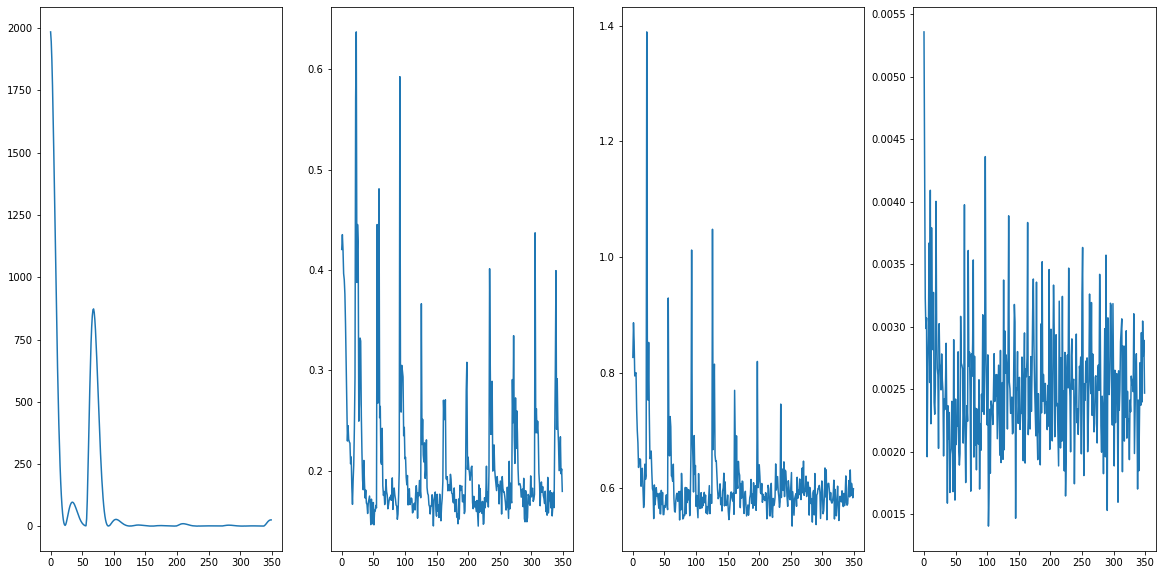

In [126]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].plot(history_loss)
ax[1].plot(history_loss_output1)
ax[2].plot(history_loss_output2)
ax[3].plot(history_loss_output3)

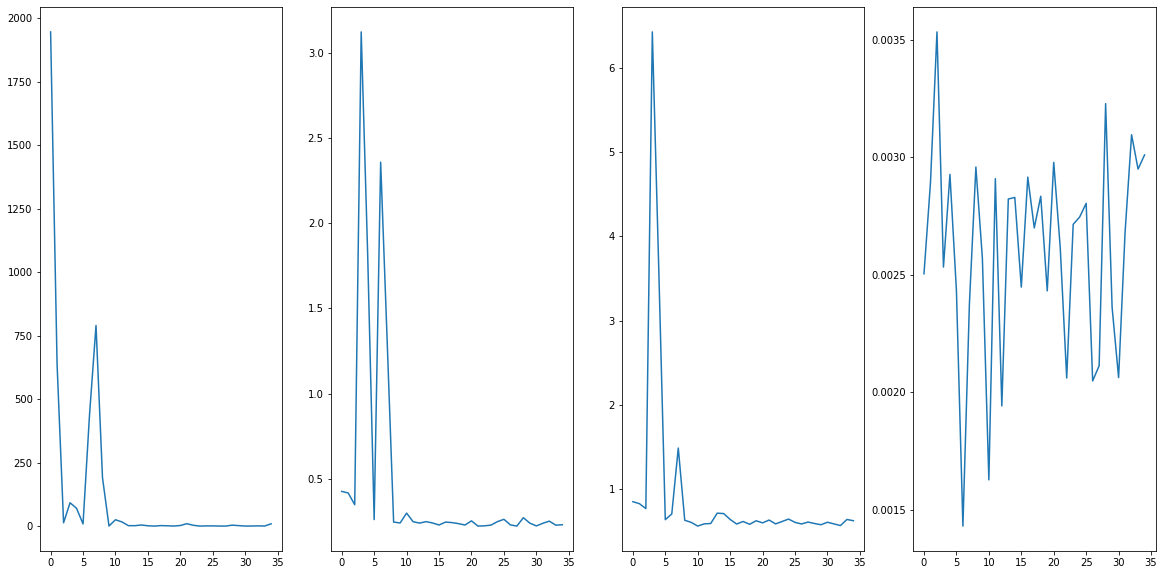

In [127]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].plot(history_val_loss)
ax[1].plot(history_val_loss_output1)
ax[2].plot(history_val_loss_output2)
ax[3].plot(history_val_loss_output3)

In [128]:

## Plot loss
plot_loss(history_loss, history_val_loss, "Global Loss", "/content/data/global_loss.png")
plot_loss(history_loss_output1, history_val_loss_output1, "Output 1 Loss", "/content/data/output_1_loss.png")
plot_loss(history_loss_output2, history_val_loss_output2, "Output 2 Loss", "/content/data/output_2_loss.png")
plot_loss(history_loss_output3, history_val_loss_output3, "Output 3 Loss", "/content/data/output_3_loss.png")
    
## Plot time
plot_time(history_time_train, "Train time", "/content/data/train_time.png")
plot_time(history_time_test, "Test time", "/content/data/test_time.png")

In [129]:
y_hat = net.predict(np.expand_dims(batch_chargrid[index], axis=0))

In [130]:
print(y_hat[0][0].shape)
print(y_hat[1][0].shape)
print(y_hat[2][0].shape)

(256, 128, 5)
(256, 128, 8)
(256, 128, 16)


In [131]:
width

128

In [132]:
height

256

In [138]:
y_hat[2][0][80][60]

array([0.00619133, 0.00592885, 0.00802824, 0.00624506, 0.00742416,
       0.00685948, 0.028175  , 0.00808612, 0.00384994, 0.00390925,
       0.01936958, 0.0047507 , 0.00298191, 0.0053667 , 0.00796592,
       0.00572506], dtype=float32)

In [137]:
batch_coord[index][80][60]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33192686, 0.30909744, 0.52832119,
       0.33001111])

In [135]:
y_hat[1][0][80][60]

array([0.01783407, 0.23602688, 0.02334761, 0.21865062, 0.02154964,
       0.23486224, 0.01815089, 0.22957805], dtype=float32)

In [133]:
batch_mask[index][80][60]

array([0., 1., 0., 1., 0., 1., 1., 0.])

In [139]:
batch_seg[index][80][60]

array([0., 0., 0., 0., 1.])

In [140]:
y_hat[0][0][80][60]

array([0.7771409 , 0.04209816, 0.06591573, 0.05888954, 0.05595561],
      dtype=float32)

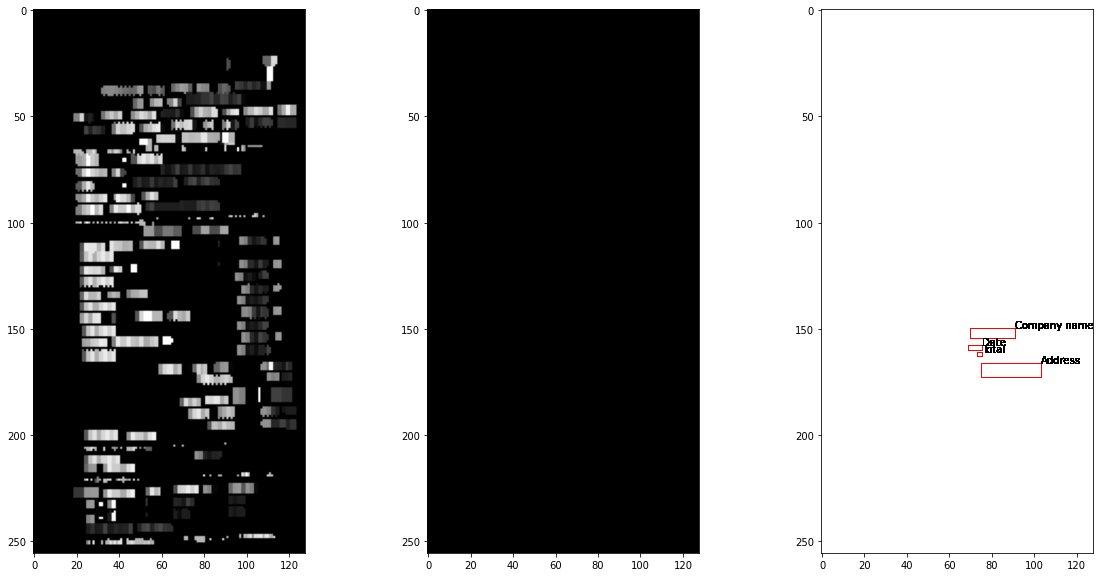

In [141]:
class_mapping = {
                0 : 'Total', 
                1 : 'Address', 
                2 : 'Company name', 
                3 : 'Date'
} 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(np.argmax(batch_chargrid[index], axis=2), cmap='gray')
ax[1].imshow(np.argmax(y_hat[0][0], axis=2), cmap='gray')
white = np.zeros([batch_chargrid[index].shape[0], batch_chargrid[index].shape[1],3],dtype=np.uint8)
white.fill(255)
ax[2].imshow(white)
#for i in range(0, y_hat[2][0].shape[0]):
#  for j in range(0, y_hat[2][0].shape[1]):
for i in range(0,10):
  for j in range(0, 10):
    if (np.sum(y_hat[2][0][i][j])==0):
      continue
    # print(batch_coord[1][i][j])
    for k in range(0, 4):
      left = y_hat[2][0][i][j][4*k]  * np.var(range(1,width +1)) + np.mean(range(1,width +1))#* width
      top = y_hat[2][0][i][j][4*k+1] * np.var(range(1,height +1)) + np.mean(range(1,height +1))#* height
      right = y_hat[2][0][i][j][4*k+2] * np.var(range(1,width +1)) + np.mean(range(1,width +1))#* width
      bottom = y_hat[2][0][i][j][4*k+3] * np.var(range(1,height +1)) + np.mean(range(1,height +1))#* height
      rect1 = patches.Rectangle((left, top),
                        (right - left),
                        (bottom - top),
                        linewidth=1,edgecolor='r',facecolor='none')
      ax[2].add_patch(rect1)
      ax[2].text(left + (right - left),top,class_mapping[k]) 
plt.show()


In [97]:
a=y_hat[2][0]
a.shape
b= [j for i in a for j in i]
print(np.array(b).shape)
c = list()
for i in b:
  if i not in c:
    c.append(i) 
c =np.array(c)
print(c.shape)
#d=np.array(d)
#d.shape

(32768, 16)


TypeError: ignored

In [99]:
a=y_hat[2][0]
a.shape
b= [j for i in a for j in i]
print(np.array(b).shape)

(32768, 16)
